In [1]:
#import image from the computer
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import imageio
from findpeaks import findpeaks
import scipy as sp

volume_properties= []

In [5]:
def extract_color(material_number,masked_img, peaks, show_graphs=False):
    masked_hsv_img = cv.cvtColor(masked_img, cv.COLOR_RGB2HSV)

    h = masked_hsv_img[:,:,0]
    s = masked_hsv_img[:,:,1]
    v = masked_hsv_img[:,:,2]

    hist_h = cv.calcHist([h],[0],None,[256],[1,256])
    hist_s = cv.calcHist([s],[0],None,[256],[1,255])
    hist_v = cv.calcHist([v],[0],None,[256],[1,255]) # excluding black background
    
    peaks_s,fp_scipy_s = sp.signal.find_peaks(hist_s.transpose()[0], prominence = 50, distance = 5, wlen=40)
    if (len(fp_scipy_s['prominences'])!=0):
        peak_location= np.argmax(fp_scipy_s['prominences'])
        saturation= peaks_s[peak_location]
    else:
        print('invalid material Saturation')
        material_number ='N'
    
    
    peaks_v,fp_scipy_v = sp.signal.find_peaks(hist_v.transpose()[0], prominence = 50, distance = 5, wlen=40)
    if (len(fp_scipy_v['prominences'])!=0):
        peak_location= np.argmax(fp_scipy_v['prominences'])
        value= peaks_v[peak_location]
    else:
        print('invalid material Value')
        material_number= 'N'
    
    if material_number !='N':
        hue= peaks[material_number]

    if(show_graphs and material_number !='N'):
        plt.subplot(1, 2, 1) 
        plt.plot(hist_h, color='r', label="hue")
        plt.title(' Hue of the segmented object (excluding zero)')
        
        plt.subplot(1, 2, 2)
        plt.plot(hist_s, color='g', label="saturation")
        plt.title(' Sat of the segmented object (excluding zero)')
        plt.show()

        plt.subplot(1, 2, 1)
        plt.plot(hist_v, color='b', label="value")
        plt.title(' Value of the segmented object (excluding zero and max)')
        plt.show()

        # show the color with different V and S
        color_prominence= np.ones((250,250,3))

        color_prominence[:,:,0]= hue
        for i in range(0,250):
            color_prominence[:,i,1]= color_prominence[:,i,1]* i #S
            color_prominence[i,:,2]= color_prominence[i,:,2]* (250-i) # V

        color_prominence = cv.convertScaleAbs(color_prominence)
        color_prominence_RGB = cv.cvtColor(color_prominence, cv.COLOR_HSV2RGB)
        plt.imshow(color_prominence_RGB)
        plt.xlabel('Increasing Saturation --> ')
        plt.ylabel('Increasing Value -->')
        plt.title('The extracted hue of the object')
        plt.axis('off')
        plt.figure()
        
    if material_number !='N':

        final_color=np.ones((50,50,3))
        final_color[:,:,0]=  hue
        final_color[:,:,1]=  saturation
        final_color[:,:,2]=  value 
        final_color = cv.convertScaleAbs(final_color)
        final_color_RGB = cv.cvtColor(final_color, cv.COLOR_HSV2RGB)
    
        plt.subplot(1, 2, 1) # row 1, col 2 index 1
        plt.imshow(masked_img)
        plt.axis('off')
    
        plt.subplot(1, 2, 2) # index 2
        plt.imshow(final_color_RGB)
        #plt.title('Final colour of object')
        plt.axis('off')
        plt.figure()


        print('material', material_number,'HSV', hue, saturation,value)
    
        material_color_hsv= np.uint8([[[hue,saturation,value]]])  
        material_color_rgb = cv.cvtColor(material_color_hsv, cv.COLOR_HSV2RGB)
        # mat_number, where it acts, rgb alpha, enabled?
        volume_properties.append([material_number,0,material_color_rgb[0][0][0], material_color_rgb[0][0][1], material_color_rgb[0][0][2], 255, 1])


In [3]:
def hsv_analysis(rgb_img,show_graphs= False):
    
    hsv_img = cv.cvtColor(rgb_img, cv.COLOR_RGB2HSV)

    pixel_total= hsv_img.shape[0]*hsv_img.shape[1]
    saved_masked_img= rgb_img

    h = hsv_img[:,:,0]
    s = hsv_img[:,:,1]
    v = hsv_img[:,:,2]

    hist_h = cv.calcHist([h],[0],None,[256],[0,256])
    hist_s = cv.calcHist([s],[0],None,[256],[0,256])
    hist_v = cv.calcHist([v],[0],None,[256],[0,256])

    peaks,fp_scipy = sp.signal.find_peaks(hist_h.transpose()[0], prominence = 1000, distance = 5, wlen=40)

    print('There are ',len(fp_scipy['prominences']),'Hue peaks')
    for material_number in range(len(fp_scipy['prominences'])):

        #mask for object segmentation
        lower_mask = hsv_img[:,:,0] > fp_scipy['left_bases'][material_number] 
        upper_mask = hsv_img[:,:,0] < fp_scipy['right_bases'][material_number]
        mask = upper_mask*lower_mask

        #show segmented image
        red = rgb_img[:,:,0]*mask
        green = rgb_img[:,:,1]*mask
        blue = rgb_img[:,:,2]*mask
        masked_img = np.dstack((red,green,blue))
        if material_number == 0:
            saved_masked_img = masked_img
        extract_color(material_number, masked_img, peaks,show_graphs)
    return saved_masked_img

There are  4 Hue peaks


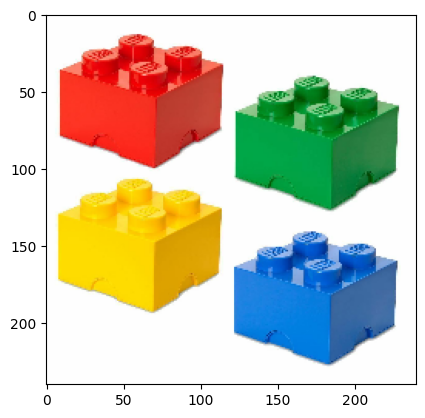

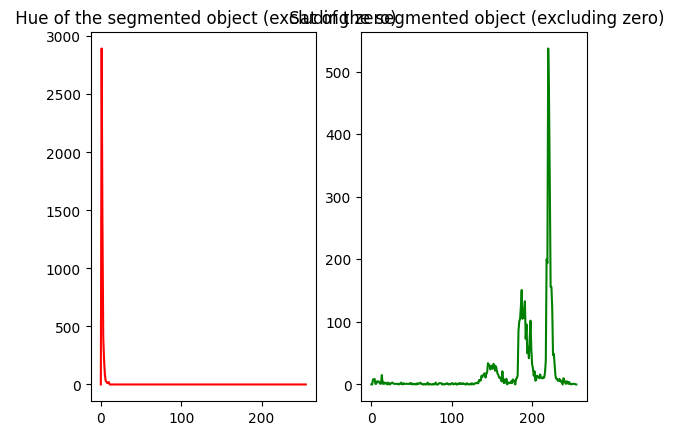

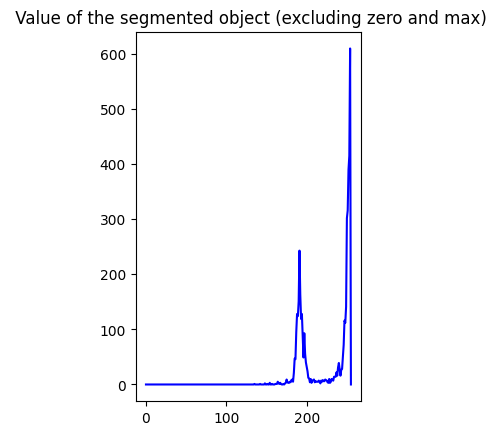

material 0 HSV 2 220 254


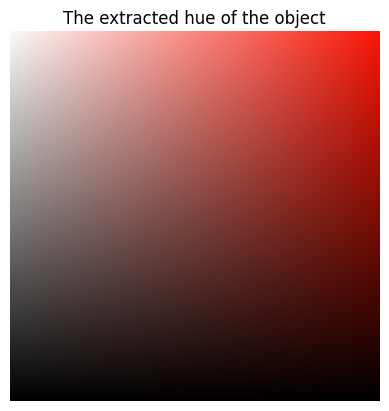

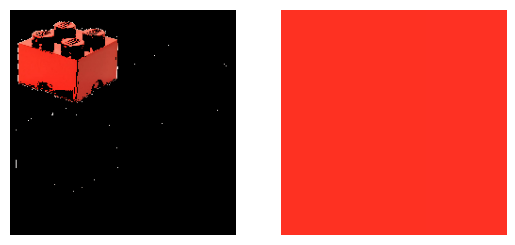

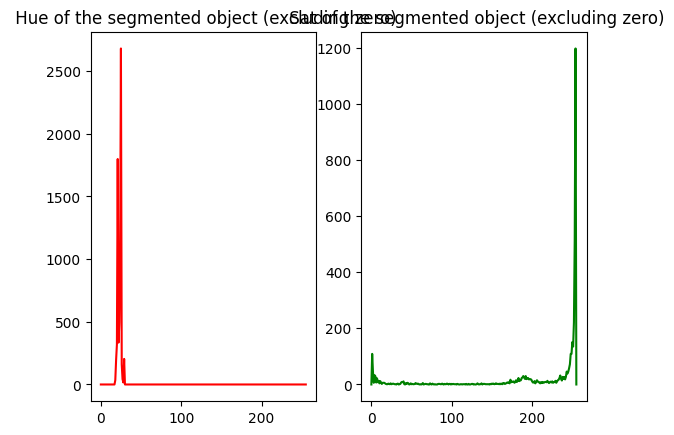

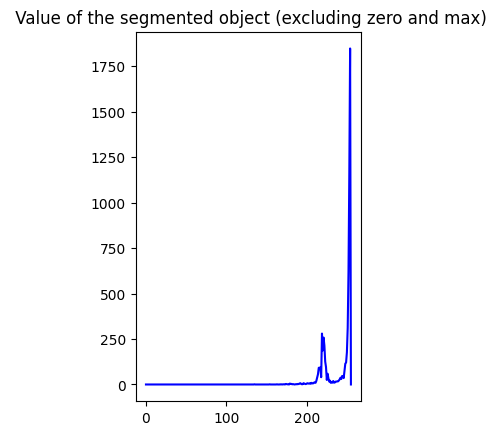

material 1 HSV 26 254 254


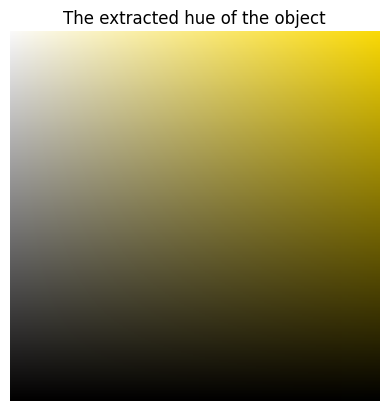

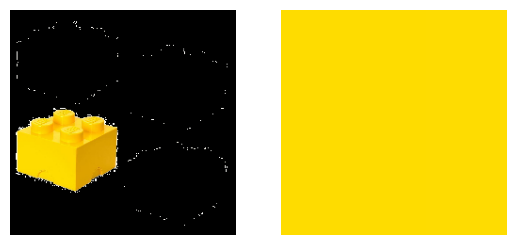

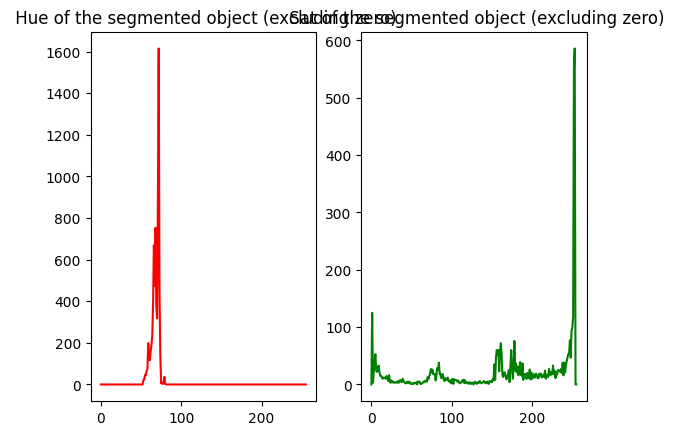

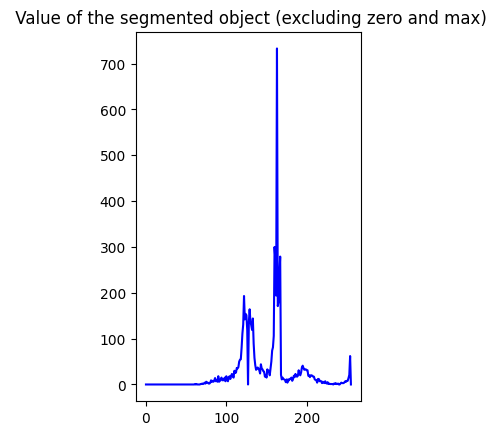

material 2 HSV 73 253 163


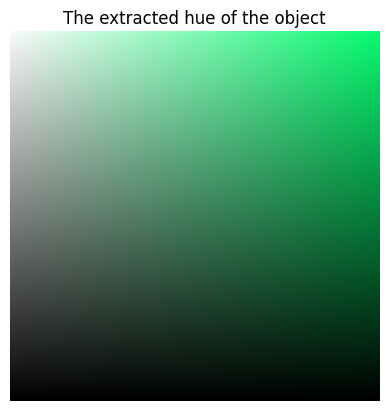

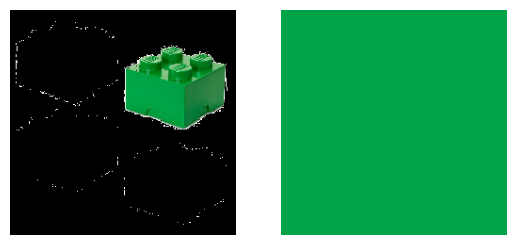

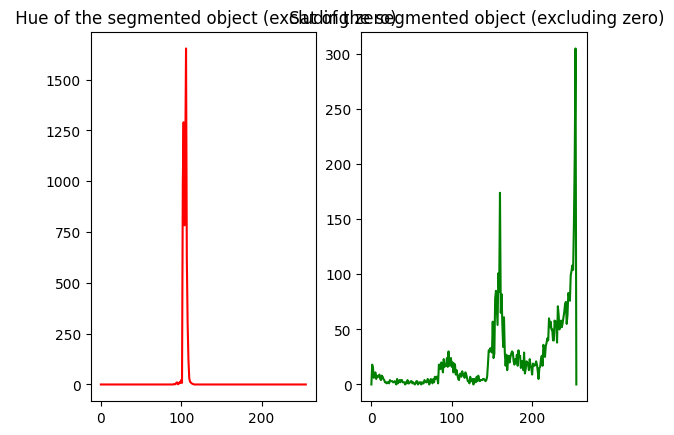

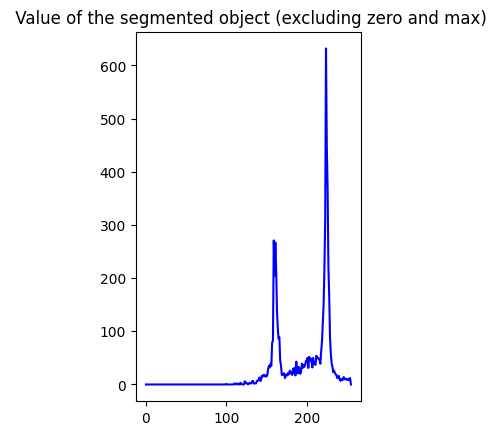

material 3 HSV 107 254 224


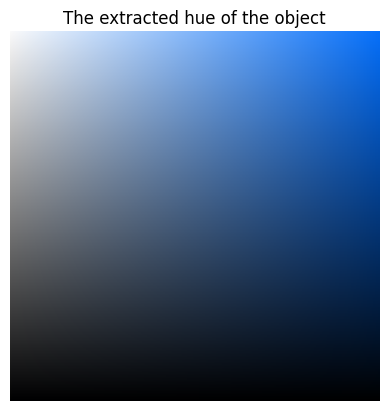

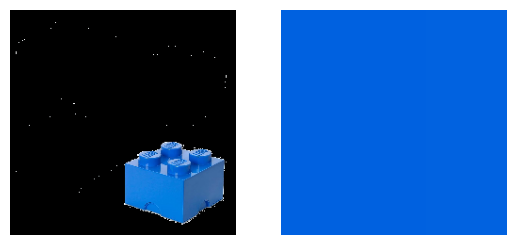

<Figure size 640x480 with 0 Axes>

In [9]:
rgb_img = imageio.imread("photos/lego_sample.png")
plt.imshow(rgb_img)
plt.figure()

#blurring
kernel_size=11
#smooth_img = cv.GaussianBlur(rgb_img, (kernel_size, kernel_size), 0)
#plt.imshow(smooth_img)

saved_masked_img=hsv_analysis(rgb_img, 1)

peaks in saturation
   - can be different sides of a material 
   - highest saturation has light illumiating it the most 
   - 
peaks in value
   -  separated peaks may signify different materials (for example backround color bleeding)
   -  threshold into different sections if the peaks are separated 
   - calculate how many pixels correspond to these materials via area
   

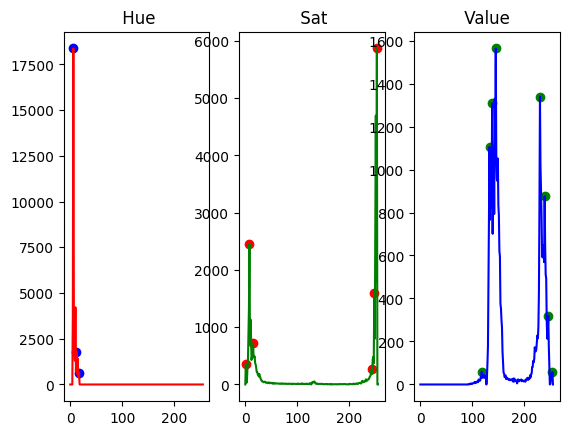

In [ ]:
# more sophysticated sat and value calculation

material_number=0
masked_hsv_img = cv.cvtColor(saved_masked_img, cv.COLOR_RGB2HSV)

h = masked_hsv_img[:,:,0]
s = masked_hsv_img[:,:,1]
v = masked_hsv_img[:,:,2]

hist_h = cv.calcHist([h],[0],None,[256],[1,256])
hist_s = cv.calcHist([s],[0],None,[256],[1,255])
hist_v = cv.calcHist([v],[0],None,[256],[1,255]) # excluding black background

peaks_h,fp_scipy_h = sp.signal.find_peaks(hist_h.transpose()[0], prominence = 50, distance = 5, wlen=40)

    
peaks_s,fp_scipy_s = sp.signal.find_peaks(hist_s.transpose()[0], prominence = 50, distance = 5, wlen=40)
if (len(fp_scipy_s['prominences'])!=0):
    peak_location= np.argmax(fp_scipy_s['prominences'])
    saturation= peaks_s[peak_location]
else:
    print('invalid material Saturation')
    material_number ='N'
    
    
peaks_v,fp_scipy_v = sp.signal.find_peaks(hist_v.transpose()[0], prominence = 50, distance = 5, wlen=40)
if (len(fp_scipy_v['prominences'])!=0):
    peak_location= np.argmax(fp_scipy_v['prominences'])
    value= peaks_v[peak_location]
else:
    print('invalid material Value')
    material_number= 'N'

if material_number !='N':
    hue= peaks_h[material_number]

plt.subplot(1, 3, 1) 
plt.plot(hist_h, color='r', label="hue")
plt.scatter(peaks_h, hist_h[peaks_h], color='b')
plt.title(' Hue')

plt.subplot(1, 3, 2)
plt.plot(hist_s, color='g', label="saturation")
plt.scatter(peaks_s, hist_s[peaks_s], color='r')
plt.title(' Sat')

plt.subplot(1, 3, 3)
plt.plot(hist_v, color='b', label="value")
plt.scatter(peaks_v, hist_v[peaks_v], color='g')
plt.title(' Value ')
plt.show()

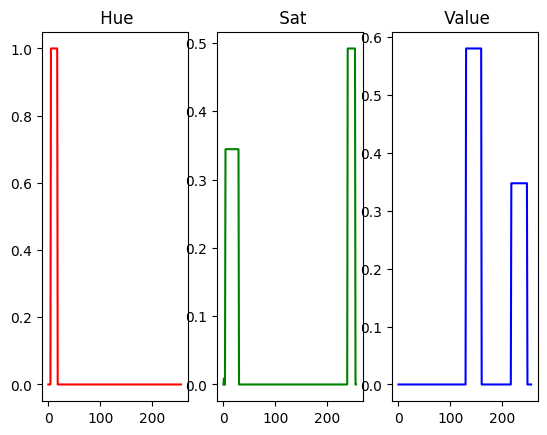

In [ ]:
# write an algorytm that looks though the histogram and outputs 1 when the data is over a threshold and 0 when it is below
# calculate pixel_total_masked that is in saved_masked_img. add 1 to the total is the pixel is not black
pixel_total_masked = 0
for i in range(0, saved_masked_img.shape[0]):
    for j in range(0, saved_masked_img.shape[1]):
        if saved_masked_img[i][j][0] != 0:
            pixel_total_masked += 1


            
threshold = 100
h_threshold = hist_h > threshold
s_threshold = hist_s > threshold
v_threshold = hist_v > threshold

h_threshold = h_threshold.astype(int)
s_threshold = s_threshold.astype(int)
v_threshold = v_threshold.astype(int)

#calaculate the area of the histogram in each region where the threshold is 1 as a pulse
h_pulse_area = np.sum(h_threshold)
s_pulse_area = np.sum(s_threshold)
v_pulse_area = np.sum(v_threshold)

#calculate the nummver of pulses in each array and store in another array when each pulse starts and ends
h_pulse_start = []
h_pulse_end = []
s_pulse_start = []
s_pulse_end = []
v_pulse_start = []
v_pulse_end = []

for i in range(1, len(h_threshold)):
    if h_threshold[i] == 1 and h_threshold[i-1] == 0:
        h_pulse_start.append(i)
    if h_threshold[i] == 0 and h_threshold[i-1] == 1:
        h_pulse_end.append(i)

for i in range(1, len(s_threshold)):
    if s_threshold[i] == 1 and s_threshold[i-1] == 0:
        s_pulse_start.append(i)
    if s_threshold[i] == 0 and s_threshold[i-1] == 1:
        s_pulse_end.append(i)

for i in range(1, len(v_threshold)):
    if v_threshold[i] == 1 and v_threshold[i-1] == 0:
        v_pulse_start.append(i)
    if v_threshold[i] == 0 and v_threshold[i-1] == 1:
        v_pulse_end.append(i)

# use this to calculate the area from the pulse start to the pulse end

h_pulse_area = []
s_pulse_area = []
v_pulse_area = []

for i in range(0, len(h_pulse_start)):
    h_pulse_area.append(np.sum(hist_h[h_pulse_start[i]:h_pulse_end[i]]))
    h_threshold[h_pulse_start[i]:h_pulse_end[i]] = h_pulse_area[i]

for i in range(0, len(s_pulse_start)):
    s_pulse_area.append(np.sum(hist_s[s_pulse_start[i]:s_pulse_end[i]]))
    s_threshold[s_pulse_start[i]:s_pulse_end[i]] = s_pulse_area[i]


for i in range(0, len(v_pulse_start)):
    v_pulse_area.append(np.sum(hist_v[v_pulse_start[i]:v_pulse_end[i]]))
    v_threshold[v_pulse_start[i]:v_pulse_end[i]] = v_pulse_area[i]
#plot the pulses from start to end, with the area of the pulse as the height of the bar

# devide by the number of pixels in the image to get the percentage of the image that is in each pulse
h_threshold = np.divide(h_threshold, pixel_total_masked)
s_threshold = np.divide(s_threshold, pixel_total_masked)
v_threshold = np.divide(v_threshold, pixel_total_masked)





plt.subplot(1, 3, 1)
plt.plot(h_threshold, color='r', label="hue")
plt.title(' Hue')
plt.subplot(1, 3, 2)
plt.plot(s_threshold, color='g', label="saturation")
plt.title(' Sat')
plt.subplot(1, 3, 3)
plt.plot(v_threshold, color='b', label="value")
plt.title(' Value')
plt.show()



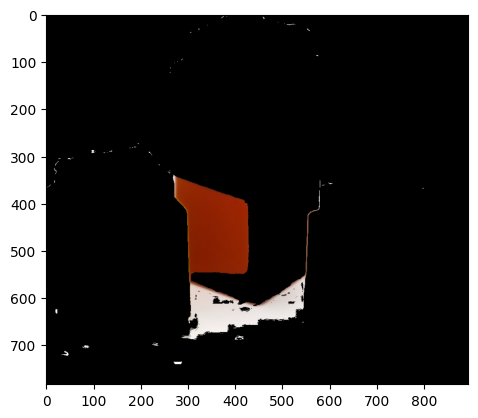

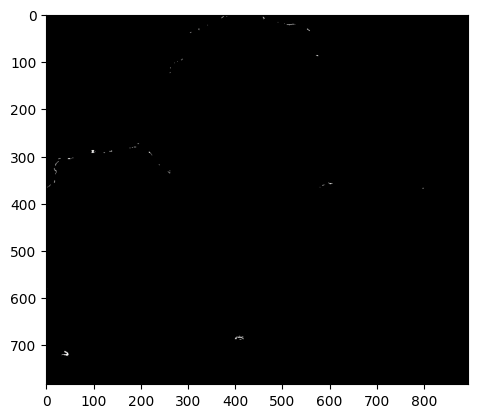

invalid material Value


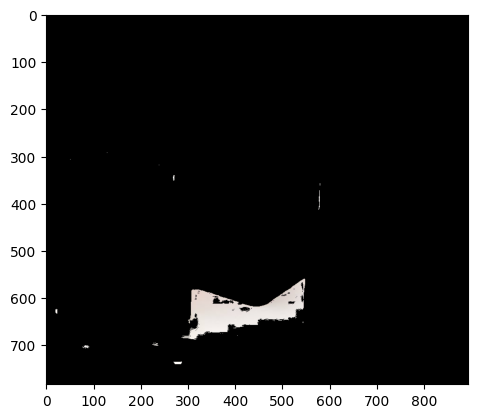

material 0 HSV 6 8 230


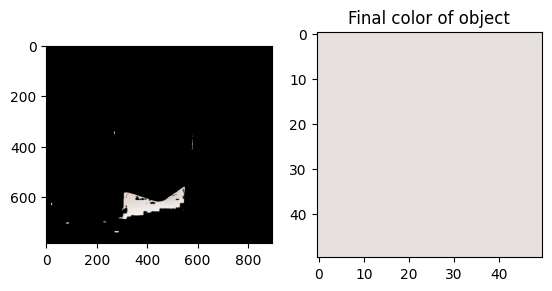

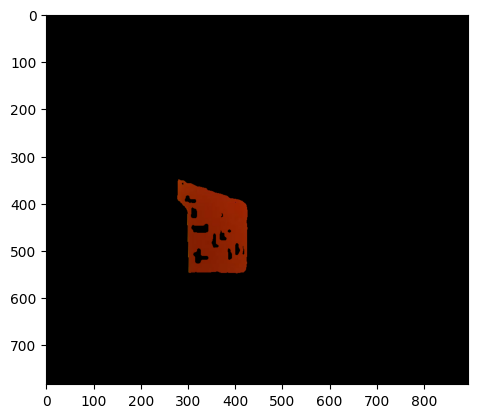

material 0 HSV 6 253 145


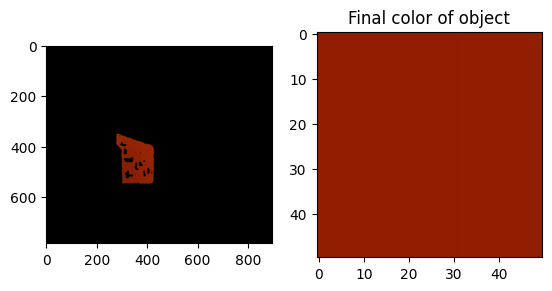

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.imshow(saved_masked_img)
plt.show()

hist_h = cv.calcHist([masked_hsv_img[:,:,0]],[0],None,[256],[1,256])
peaks,fp_scipy = sp.signal.find_peaks(hist_h.transpose()[0], prominence = 1000, distance = 5, wlen=40)

#mask the image for each of the three pulses of the saturations
lower_mask = masked_hsv_img[:,:,1] >= s_pulse_start[0]
upper_mask = masked_hsv_img[:,:,1] <= s_pulse_end[0]

mask = upper_mask*lower_mask

#show segmented image
red = rgb_img[:,:,0]*mask
green = rgb_img[:,:,1]*mask
blue = rgb_img[:,:,2]*mask
masked_img = np.dstack((red,green,blue))
plt.imshow(masked_img)
plt.show()

 
extract_color(0, masked_img, peaks,0)

lower_mask = masked_hsv_img[:,:,1] >= s_pulse_start[1]
upper_mask = masked_hsv_img[:,:,1] <= s_pulse_end[1]

mask = upper_mask*lower_mask

#show segmented image
red = rgb_img[:,:,0]*mask
green = rgb_img[:,:,1]*mask
blue = rgb_img[:,:,2]*mask
masked_img = np.dstack((red,green,blue))
plt.imshow(masked_img)
plt.show()

extract_color(0, masked_img, peaks,0)

lower_mask = masked_hsv_img[:,:,1] >= s_pulse_start[2]
upper_mask = masked_hsv_img[:,:,1] <= s_pulse_end[2]

mask = upper_mask*lower_mask

#show segmented image
red = rgb_img[:,:,0]*mask
green = rgb_img[:,:,1]*mask
blue = rgb_img[:,:,2]*mask
masked_img = np.dstack((red,green,blue))
plt.imshow(masked_img)
plt.show()

extract_color(0, masked_img, peaks,0)
